# Behavioral clonning

In this notebook, I wrote an implementation of a deep NN to drive a car in a simulator.

## Loading the data and pre-processing

In this first step, I am downloading the data I got from different "runs" I made on the circuit. To download the data, I am reading the csv file created with data from the three images we created plus the stearing angles. 


In [1]:
import csv
import cv2
import os.path
import numpy as np
import sklearn
from sklearn.utils import shuffle

BATCH_SIZE = 32
THRESHOLD = 0.02

def get_samples(path):
    samples = []
    with open(path + '/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            # Remove ~94% of the samples, that have small angle
            if (float(line[3]) > THRESHOLD or np.random.rand() < 0.06):
                samples.append(line)
        del(samples[0]) # removing first line in case of header
    return samples

# 0 for center, 1 for left, 2 for right
def get_data(batch_samples, path, image_type):
    if image_type > 2 or image_type < 0:
        image_type = 0
    images = []
    angles = []
    correction = 0
    if image_type == 1:
        correction = 0.2
    elif image_type == 2:
        correction = -0.2
    
    for batch_sample in batch_samples:
        name = path + '/IMG/' + batch_sample[image_type].split('/')[-1]
        angle = float(batch_sample[3])
        angle += correction
        angles.append(angle)
        images.append(cv2.imread(name))
    return images, angles
    
def flip(images, angles):
    f_images = [cv2.flip(x,1) for x in images]
    f_angles = [-x for x in angles]
    return f_images, f_angles
    
def generator(samples, path, batch_size=BATCH_SIZE):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            if offset+batch_size <= num_samples:
                batch_samples = samples[offset:offset+batch_size]
                c_images, c_angles = get_data(batch_samples, path, 0)
                l_images, l_angles = get_data(batch_samples, path, 1)
                r_images, r_angles = get_data(batch_samples, path, 2)

                cf_images, cf_angles = flip(c_images, c_angles)
                lf_images, lf_angles = flip(r_images, r_angles)
                rf_images, rf_angles = flip(l_images, l_angles)

                images = c_images
                images.extend(l_images)
                images.extend(r_images)
                images.extend(cf_images)
                images.extend(lf_images)
                images.extend(rf_images)

                angles = c_angles
                angles.extend(l_angles)
                angles.extend(r_angles)
                angles.extend(cf_angles)
                angles.extend(lf_angles)
                angles.extend(rf_angles)

                X_train = np.array(images)
                y_train = np.array(angles)
            
                yield shuffle(X_train, y_train)

In [3]:
def change_value(image):
    """
    Modifies the brightness (Value on the HSV channels) of the image to allow more robust estimation and generalization.
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image[:,:,2] = image[:,:,2] * (.1 + np.random.uniform())
    image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    return image

def maybe_flip(image, angle):
    if np.random.randint(2) == 0:
        return cv2.flip(image, 1), -angle
    return image, angle

def get_single_data(batch_sample, path, image_type):
    if image_type > 2 or image_type < 0:
        image_type = 0
    correction = 0
    if image_type == 1:
        correction = 0.2
    elif image_type == 2:
        correction = -0.2
    name = path + '/IMG/' + batch_sample[image_type].split('/')[-1]
    angle = float(batch_sample[3])
    angle += correction
    
    image = cv2.imread(name)
    image = change_value(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image, angle = maybe_flip(image, angle)
    
    return image, angle

def generator_random_changes(samples, path, batch_size = BATCH_SIZE):
    num_samples = len(samples)
    images = np.zeros((batch_size, 160, 320, 3))
    angles = np.zeros(batch_size) 
    while True:
        for n_batch in range(batch_size):
            pos = np.random.randint(num_samples)
            # 0: center, 1: left, 2: right
            position = np.random.randint(3)
            image, angle = get_single_data(samples[pos], path, position)
            
            images[n_batch] = image
            angles[n_batch] = angle
        yield images, angles

In [4]:
from sklearn.model_selection import train_test_split

PATH_1 = 'training-data'
PATH_2 = 'training-data-2'
PATH_3 = 'training-extended'
PATH_4 = 'training-data-udacity'
PATH_5 = 'training-data-3'
PATH_6 = 'training-data-4'
PATH_7 = 'circuit2-training-data'

samples_1 = get_samples(PATH_1)
samples_2 = get_samples(PATH_2)
samples_3 = get_samples(PATH_3)
samples_4 = get_samples(PATH_4)
samples_5 = get_samples(PATH_5)
samples_6 = get_samples(PATH_6)
samples_7 = get_samples(PATH_7)

train_1, val_1 = train_test_split(samples_1, test_size=0.2)
train_2, val_2 = train_test_split(samples_2, test_size=0.2)
train_3, val_3 = train_test_split(samples_3, test_size=0.2)
train_4, val_4 = train_test_split(samples_4, test_size=0.2)
train_5, val_5 = train_test_split(samples_5, test_size=0.2)
train_6, val_6 = train_test_split(samples_6, test_size=0.2)
train_7, val_7 = train_test_split(samples_7, test_size=0.2)

train_1_generator = generator(train_1, PATH_1)
val_1_generator = generator(val_1, PATH_1)
train_2_generator = generator(train_2, PATH_2)
val_2_generator = generator(val_2, PATH_2)
train_3_generator = generator(train_3, PATH_3)
val_3_generator = generator(val_3, PATH_3)
train_4_generator = generator(train_4, PATH_4)
val_4_generator = generator(val_4, PATH_4)
train_5_generator = generator(train_5, PATH_5)
val_5_generator = generator(val_5, PATH_5)
train_6_generator = generator(train_6, PATH_6)
val_6_generator = generator(val_6, PATH_6)
train_7_generator = generator(train_7, PATH_7)
val_7_generator = generator(val_7, PATH_7)

train_2_generator_changes = generator_random_changes(train_2, PATH_2)
val_2_generator_changes = generator_random_changes(val_2, PATH_2)
train_3_generator_changes = generator_random_changes(train_3, PATH_3)
val_3_generator_changes = generator_random_changes(val_3, PATH_3)
train_4_generator_changes = generator_random_changes(train_4, PATH_4)
val_4_generator_changes = generator_random_changes(val_4, PATH_4)
train_5_generator_changes = generator_random_changes(train_5, PATH_5)
val_5_generator_changes = generator_random_changes(val_5, PATH_5)
train_6_generator_changes = generator_random_changes(train_6, PATH_6)
val_6_generator_changes = generator_random_changes(val_6, PATH_6)
train_7_generator_changes = generator_random_changes(train_7, PATH_7)
val_7_generator_changes = generator_random_changes(val_7, PATH_7)

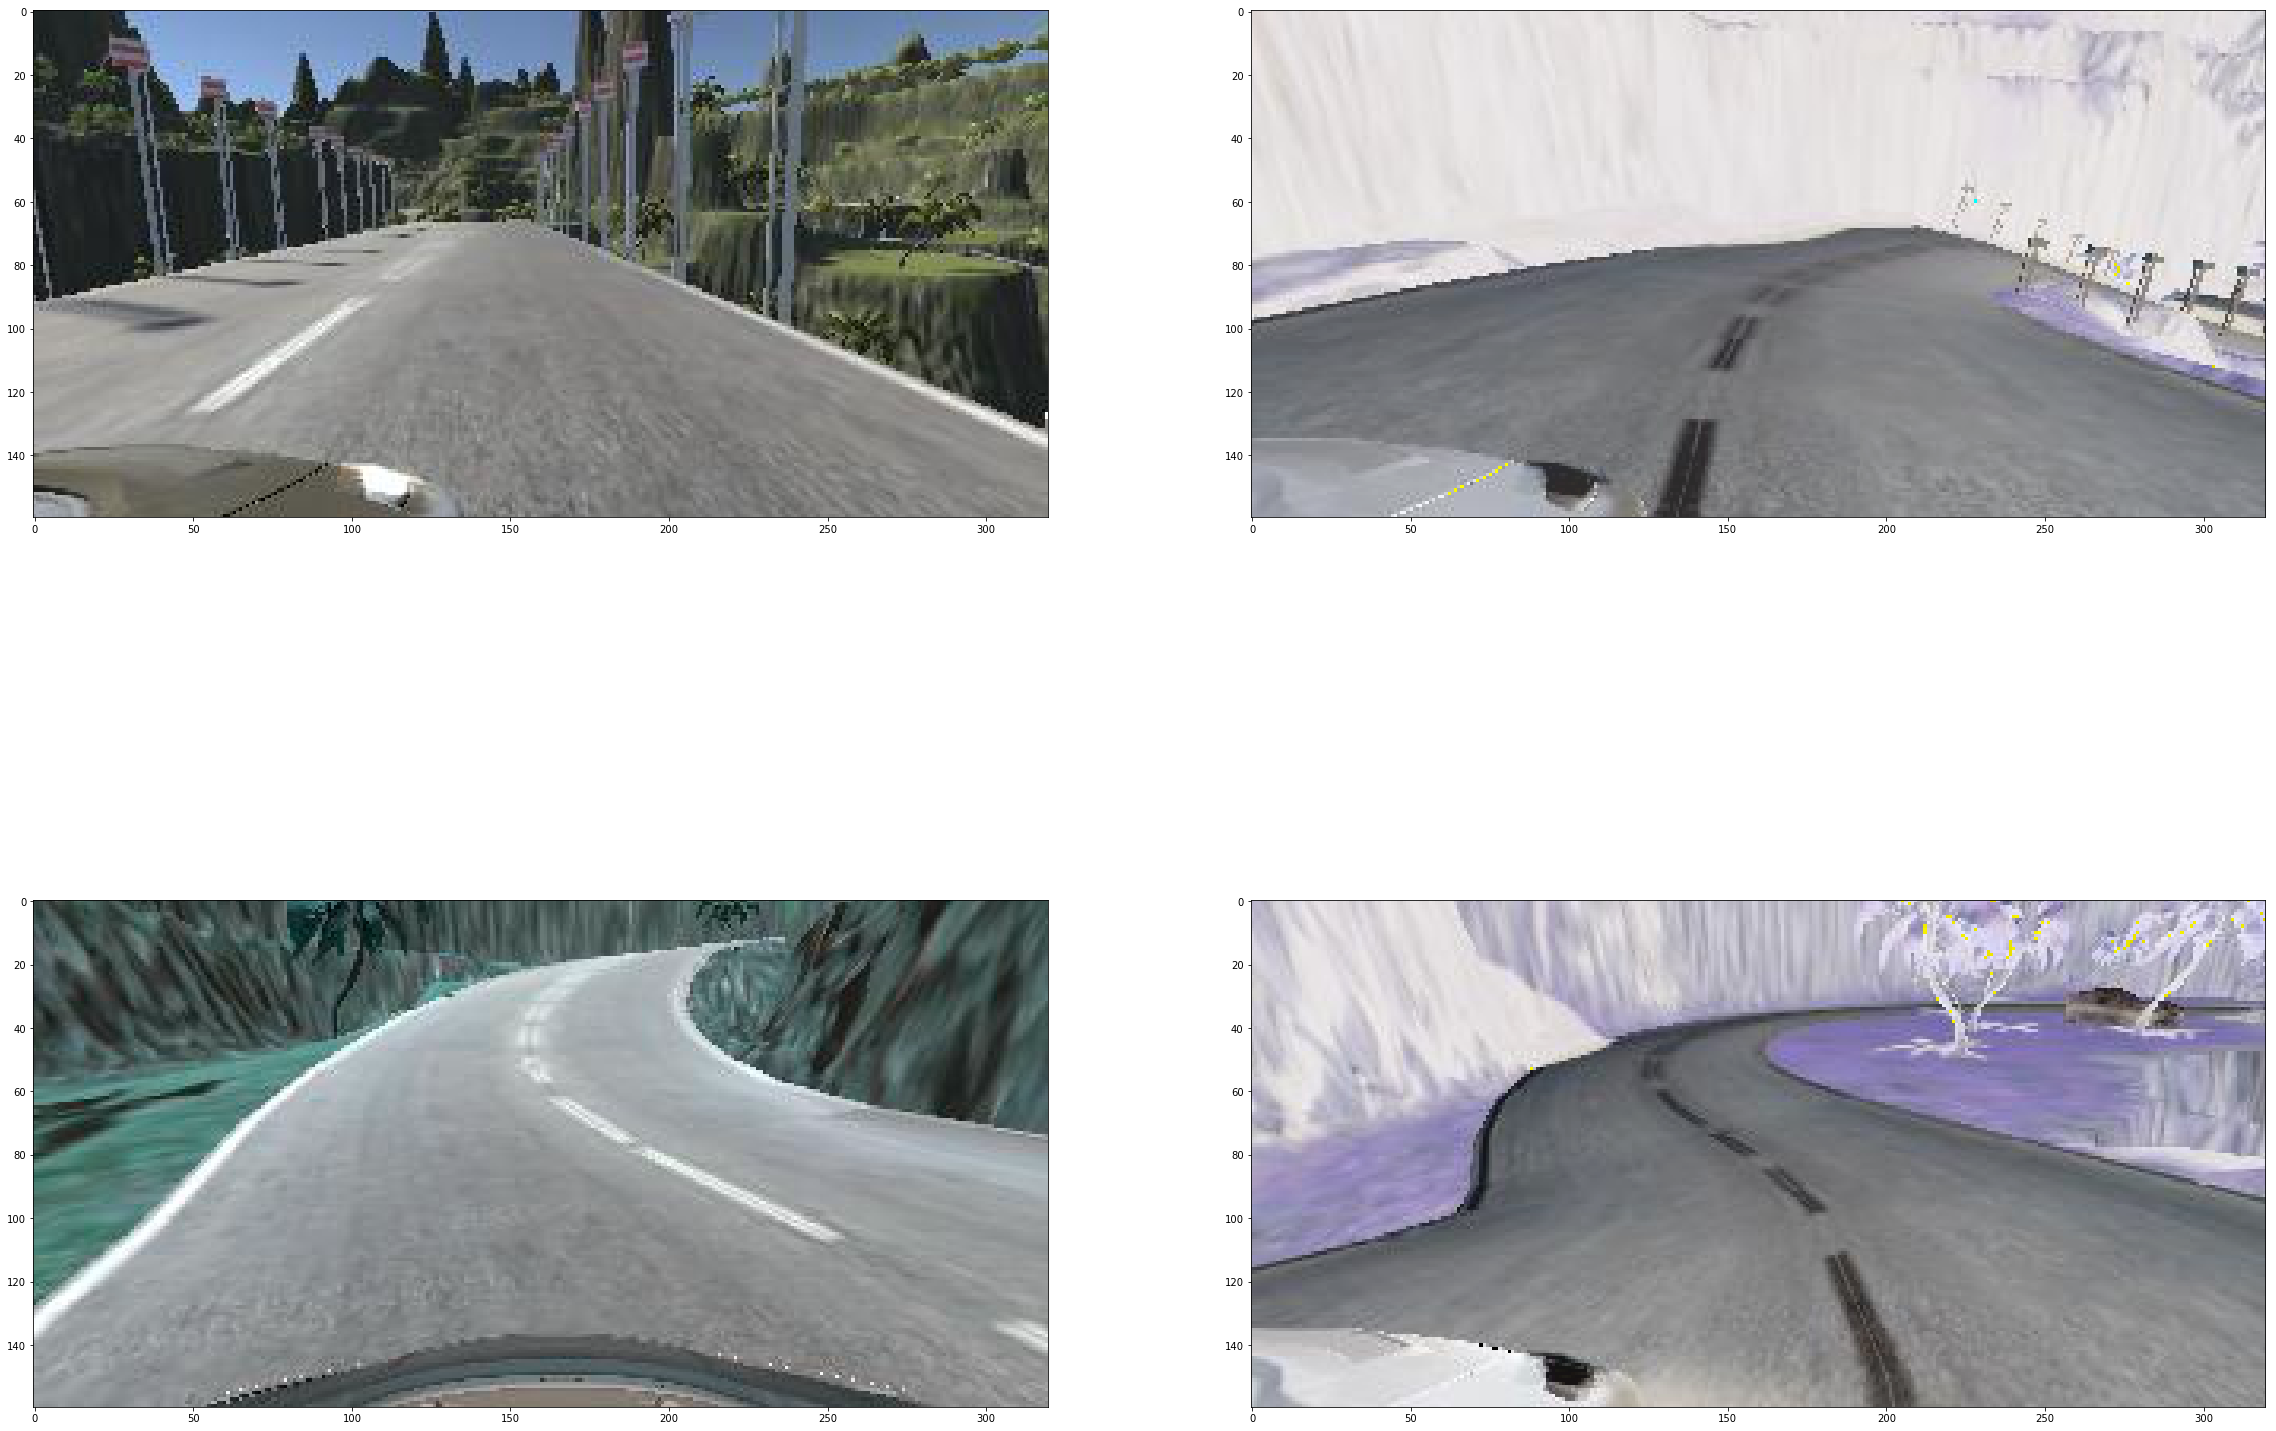

In [24]:
images, angles = next(train_7_generator_changes)
images_2, angles_2 = next(train_7_generator)

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

# Visualizations will be shown in the notebook.
%matplotlib inline

fig = plt.figure(figsize=(40,30))
ax = fig.add_subplot(2,2,1)
ax.imshow(cv2.cvtColor(images_2[0], cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(2,2,2)
ax.imshow(images[1])
ax = fig.add_subplot(2,2,3)
ax.imshow(cv2.cvtColor(images_2[2], cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(2,2,4)
ax.imshow(images[3])
plt.show()

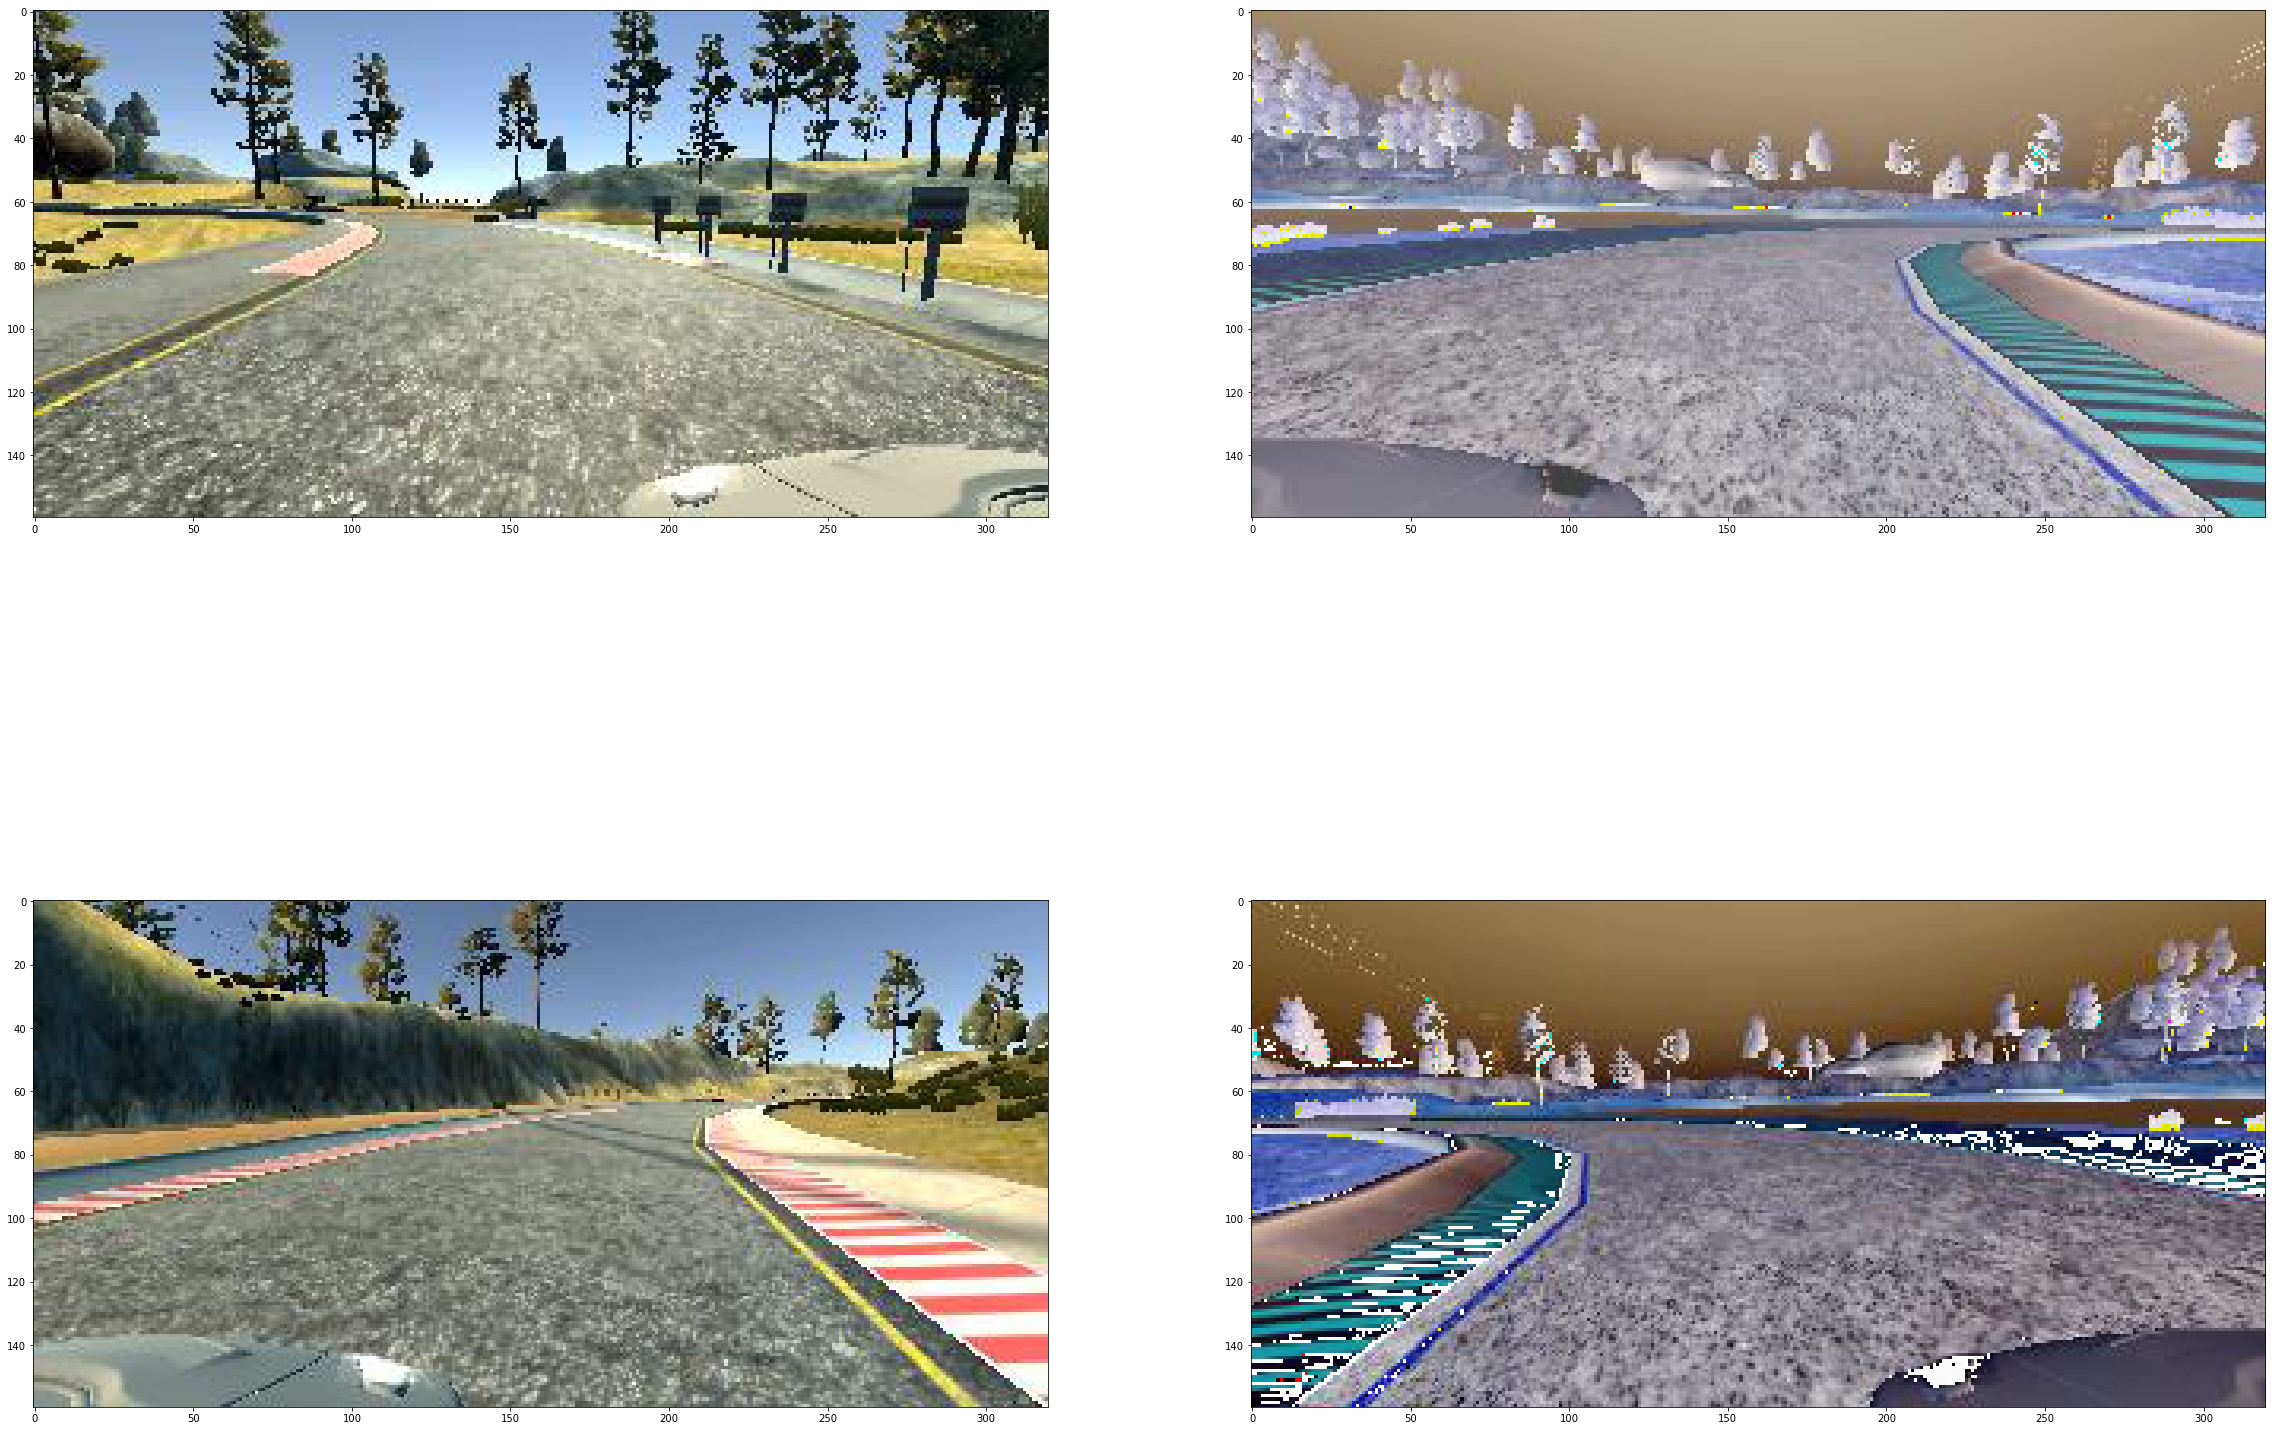

In [27]:
images, angles = next(train_6_generator_changes)
images_2, angles_2 = next(train_6_generator)

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

# Visualizations will be shown in the notebook.
%matplotlib inline

fig = plt.figure(figsize=(40,30))
ax = fig.add_subplot(2,2,1)
ax.imshow(cv2.cvtColor(images_2[0], cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(2,2,2)
ax.imshow(images[6])
ax = fig.add_subplot(2,2,3)
ax.imshow(cv2.cvtColor(images_2[2], cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(2,2,4)
ax.imshow(images[8])
plt.show()

In [ ]:
plt.axis("off")
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.show()

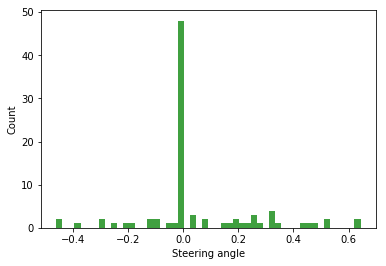

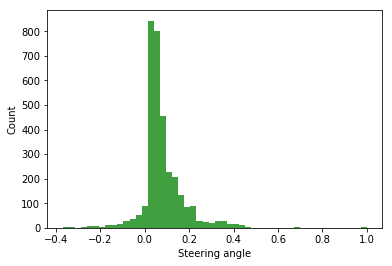

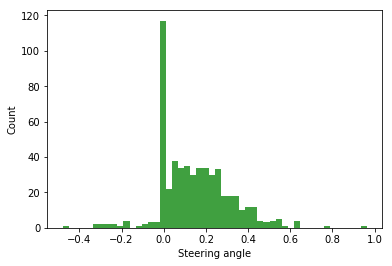

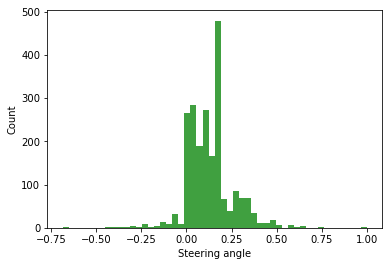

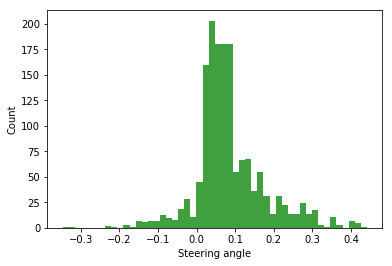

In [37]:
# Plotting some data of the angles we are trying to predict
import matplotlib.pyplot as plt

def histogram_angles(data):
    a = []
    for d in data:
        a.append(float(d[3]))
    angles = np.array(a)
    n, bins, patches = plt.hist(angles, 50, facecolor='green', alpha=0.75)
    
    plt.xlabel('Steering angle')
    plt.ylabel('Count')
    plt.show()
    
histogram_angles(samples_1)
histogram_angles(samples_2)
histogram_angles(samples_3)
histogram_angles(samples_4)
histogram_angles(samples_5)

In [4]:
# Before training, I am limiting the GPU resource dedicated to training so I can test without killing the notebook server
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [17]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, ZeroPadding2D, Cropping2D, Convolution2D, ELU
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

BATCH_SIZE = 32

def lenet_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x/127.50) - 1))
    
    model.add(Conv2D(32,5,5,activation="elu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,5,5,activation="elu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128,3,3,activation="elu"))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='elu'))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(32, activation='elu'))
    model.add(Dense(16, activation='elu'))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mse', optimizer=Adam(1e-4))
    
    return model

def nvdia_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x/127.50) - 1))
    
    model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1164, activation='elu'))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mse', optimizer=Adam(1e-4))

    return model

def nvdia_complete_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x/127.50) - 1))
    
    model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Conv2D(128, 3, 3, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mse', optimizer=Adam(1e-4))

    return model

def other_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160,320,3)))
    model.add(Lambda(lambda x: (x/127.50) - 1))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    # Maxpooling
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # 2 CNNs blocks comprised of 64 filters of size 3x3.
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    # Maxpooling + Dropout to avoid overfitting
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))    

    # 2 CNNs blocks comprised of 128 filters of size 3x3.
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    # Last Maxpooling. We went from an image (64, 64, 3), to an array of shape (8, 8, 128)
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))    

    # Fully connected layers part.
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    # Dropout here to avoid overfitting
    model.add(Dropout(0.5))    
    model.add(Dense(64, activation='relu'))
    # Last Dropout to avoid overfitting
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.summary()
    model.compile(loss='mse', optimizer=Adam(1e-4))

    return model

model_lenet = lenet_model()
model_other = other_model()
model_nvdia = nvdia_model()
model_nvdia_complete = nvdia_complete_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_7 (Cropping2D)        (None, 65, 320, 3)    0           cropping2d_input_7[0][0]         
____________________________________________________________________________________________________
lambda_7 (Lambda)                (None, 65, 320, 3)    0           cropping2d_7[0][0]               
____________________________________________________________________________________________________
convolution2d_29 (Convolution2D) (None, 61, 316, 32)   2432        lambda_7[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_11 (MaxPooling2D)   (None, 30, 158, 32)   0           convolution2d_29[0][0]           
___________________________________________________________________________________________

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_9 (Cropping2D)        (None, 65, 320, 3)    0           cropping2d_input_9[0][0]         
____________________________________________________________________________________________________
lambda_9 (Lambda)                (None, 65, 320, 3)    0           cropping2d_9[0][0]               
____________________________________________________________________________________________________
convolution2d_38 (Convolution2D) (None, 31, 158, 24)   1824        lambda_9[0][0]                   
____________________________________________________________________________________________________
convolution2d_39 (Convolution2D) (None, 14, 77, 36)    21636       convolution2d_38[0][0]           
___________________________________________________________________________________________

In [38]:
model_lenet.fit_generator(train_2_generator, samples_per_epoch = 3*(len(train_2)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_2_generator, nb_val_samples=len(val_2), nb_epoch=10)
model_lenet.save('train_2.lenet_model')
model_lenet.fit_generator(train_3_generator, samples_per_epoch = 3*(len(train_3)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_3_generator, nb_val_samples=len(val_3), nb_epoch=10)
model_lenet.save('train_3.lenet_model')
model_lenet.fit_generator(train_4_generator, samples_per_epoch = 3*(len(train_4)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_4_generator, nb_val_samples=len(val_4), nb_epoch=10)
model_lenet.save('train_4.lenet_model')
model_lenet.fit_generator(train_5_generator, samples_per_epoch = 3*(len(train_5)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_5_generator, nb_val_samples=len(val_5), nb_epoch=10)
model_lenet.save('train_5.lenet_model')
model_lenet.fit_generator(train_6_generator, samples_per_epoch = 3*(len(train_5)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_6_generator, nb_val_samples=len(val_5), nb_epoch=10)
model_lenet.save('train_6.lenet_model')

Epoch 1/10
7872/7872 [==============================] - 10s - loss: 5.1361 - val_loss: 3.9473
Epoch 2/10
7872/7872 [==============================] - 9s - loss: 4.0884 - val_loss: 3.4984
Epoch 3/10
7872/7872 [==============================] - 9s - loss: 3.8711 - val_loss: 2.3575
Epoch 4/10
7872/7872 [==============================] - 9s - loss: 3.3807 - val_loss: 2.2502
Epoch 5/10
7872/7872 [==============================] - 9s - loss: 3.3087 - val_loss: 1.9208
Epoch 6/10
7872/7872 [==============================] - 9s - loss: 3.1154 - val_loss: 2.1649
Epoch 7/10
7872/7872 [==============================] - 9s - loss: 3.1493 - val_loss: 2.0524
Epoch 8/10
7872/7872 [==============================] - 9s - loss: 2.7220 - val_loss: 2.7908
Epoch 9/10
7872/7872 [==============================] - 9s - loss: 2.9125 - val_loss: 2.0667
Epoch 10/10
7872/7872 [==============================] - 9s - loss: 2.4620 - val_loss: 2.0126
Epoch 1/10
1344/1248 [================================] - 1s - loss:

/home/sergi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/10
1344/1248 [================================] - 1s - loss: 2.3983 - val_loss: 1.0866
Epoch 3/10
1344/1248 [================================] - 1s - loss: 2.1259 - val_loss: 1.4192
Epoch 4/10
1344/1248 [================================] - 1s - loss: 2.3913 - val_loss: 1.1629
Epoch 5/10
1344/1248 [================================] - 1s - loss: 1.9130 - val_loss: 1.5559
Epoch 6/10
1344/1248 [================================] - 1s - loss: 2.3021 - val_loss: 0.8329
Epoch 7/10
1344/1248 [================================] - 1s - loss: 1.9022 - val_loss: 1.2599
Epoch 8/10
1344/1248 [================================] - 1s - loss: 2.1583 - val_loss: 1.0322
Epoch 9/10
1344/1248 [================================] - 1s - loss: 2.0066 - val_loss: 1.0719
Epoch 10/10
1344/1248 [================================] - 1s - loss: 1.7348 - val_loss: 0.9853
Epoch 1/10
5184/5184 [==============================] - 6s - loss: 2.3276 - val_loss: 1.5460
Epoch 2/10
5184/5184 [============================

In [30]:
model_lenet.fit_generator(train_2_generator_changes, samples_per_epoch = len(train_2), validation_data=val_2_generator, nb_val_samples=len(val_2), nb_epoch=5)
model_lenet.save('train_2g.lenet_model')
model_lenet.fit_generator(train_3_generator_changes, samples_per_epoch = len(train_3), validation_data=val_3_generator, nb_val_samples=len(val_3), nb_epoch=5)
model_lenet.save('train_3g.lenet_model')
model_lenet.fit_generator(train_4_generator_changes, samples_per_epoch = len(train_4), validation_data=val_4_generator, nb_val_samples=len(val_4), nb_epoch=5)
model_lenet.save('train_4g.lenet_model')
model_lenet.fit_generator(train_5_generator_changes, samples_per_epoch = len(train_5), validation_data=val_5_generator, nb_val_samples=len(val_5), nb_epoch=5)
model_lenet.save('train_5g.lenet_model')

Epoch 1/5
2752/2768 [============================>.] - ETA: 0s - loss: 12.8688

/home/sergi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2784/2768 [==============================] - 6s - loss: 12.8481 - val_loss: 17.6108
Epoch 2/5
2784/2768 [==============================] - 5s - loss: 11.7619 - val_loss: 30.2589
Epoch 3/5
2784/2768 [==============================] - 5s - loss: 9.0886 - val_loss: 30.9435
Epoch 4/5
2784/2768 [==============================] - 5s - loss: 7.1761 - val_loss: 9.7501
Epoch 5/5
2784/2768 [==============================] - 5s - loss: 7.4582 - val_loss: 19.1828
Epoch 1/5
544/540 [==============================] - 1s - loss: 4.6071 - val_loss: 33.9909
Epoch 2/5
544/540 [==============================] - 1s - loss: 4.4606 - val_loss: 9.8698s
Epoch 3/5
544/540 [==============================] - 1s - loss: 4.2615 - val_loss: 5.4963
Epoch 4/5
544/540 [==============================] - 1s - loss: 3.8597 - val_loss: 9.0361
Epoch 5/5
544/540 [==============================] - 1s - loss: 3.7819 - val_loss: 6.3198
Epoch 1/5
1984/1973 [==============================] - 4s - loss: 3.2819 - val_loss: 33.1561

In [13]:
model_other.fit_generator(train_2_generator, samples_per_epoch = 3*(len(train_2)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_2_generator, nb_val_samples=len(val_2), nb_epoch=5)
model_other.save('train_2.other_model')
model_other.fit_generator(train_3_generator, samples_per_epoch = 3*(len(train_3)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_3_generator, nb_val_samples=len(val_3), nb_epoch=5)
model_other.save('train_3.other_model')
model_other.fit_generator(train_4_generator, samples_per_epoch = 3*(len(train_4)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_4_generator, nb_val_samples=len(val_4), nb_epoch=5)
model_other.save('train_4.other_model')
model_other.fit_generator(train_5_generator, samples_per_epoch = 3*(len(train_5)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_5_generator, nb_val_samples=len(val_5), nb_epoch=5)
model_other.save('train_5.other_model')
model_other.fit_generator(train_6_generator, samples_per_epoch = len(train_6), validation_data=val_6_generator, nb_val_samples=len(val_6), nb_epoch=5)
model_other.save('train_6.other_model')

Epoch 1/5
7680/7776 [============================>.] - ETA: 0s - loss: 0.0240

/home/sergi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


7872/7776 [==============================] - 23s - loss: 0.0239 - val_loss: 0.0190
Epoch 2/5
7872/7776 [==============================] - 22s - loss: 0.0208 - val_loss: 0.0192
Epoch 3/5
7872/7776 [==============================] - 22s - loss: 0.0198 - val_loss: 0.0190
Epoch 4/5
7872/7776 [==============================] - 22s - loss: 0.0193 - val_loss: 0.0183
Epoch 5/5
7872/7776 [==============================] - 22s - loss: 0.0180 - val_loss: 0.0160
Epoch 1/5
1344/1248 [================================] - 4s - loss: 0.0357 - val_loss: 0.0388
Epoch 2/5
1344/1248 [================================] - 3s - loss: 0.0248 - val_loss: 0.0305
Epoch 3/5
1344/1248 [================================] - 3s - loss: 0.0306 - val_loss: 0.0351
Epoch 4/5
1344/1248 [================================] - 4s - loss: 0.0251 - val_loss: 0.0328
Epoch 5/5
1344/1248 [================================] - 4s - loss: 0.0269 - val_loss: 0.0264
Epoch 1/5
5376/5280 [==============================] - 15s - loss: 0.0237 -

In [12]:
model_other.fit_generator(train_2_generator_changes, samples_per_epoch = len(train_2), validation_data=val_2_generator, nb_val_samples=len(val_2), nb_epoch=10)
model_other.save('train_2g.other_model')
model_other.fit_generator(train_3_generator_changes, samples_per_epoch = len(train_3), validation_data=val_3_generator, nb_val_samples=len(val_3), nb_epoch=10)
model_other.save('train_3g.other_model')
model_other.fit_generator(train_4_generator_changes, samples_per_epoch = len(train_4), validation_data=val_4_generator, nb_val_samples=len(val_4), nb_epoch=10)
model_other.save('train_4g.other_model')
model_other.fit_generator(train_5_generator_changes, samples_per_epoch = len(train_5), validation_data=val_5_generator, nb_val_samples=len(val_5), nb_epoch=10)
model_other.save('train_5g.other_model')
model_other.fit_generator(train_6_generator_changes, samples_per_epoch = len(train_6), validation_data=val_6_generator, nb_val_samples=len(val_6), nb_epoch=10)
model_other.save('train_6g.other_model')

Epoch 1/10
2592/2612 [============================>.] - ETA: 0s - loss: 0.0224

/home/sergi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2624/2612 [==============================] - 7s - loss: 0.0224 - val_loss: 0.0310
Epoch 2/10
2624/2612 [==============================] - 9s - loss: 0.0240 - val_loss: 0.0339
Epoch 3/10
2624/2612 [==============================] - 9s - loss: 0.0223 - val_loss: 0.0315
Epoch 4/10
2624/2612 [==============================] - 9s - loss: 0.0229 - val_loss: 0.0287
Epoch 5/10
2624/2612 [==============================] - 9s - loss: 0.0209 - val_loss: 0.0289
Epoch 6/10
2624/2612 [==============================] - 8s - loss: 0.0228 - val_loss: 0.0234
Epoch 7/10
2624/2612 [==============================] - 8s - loss: 0.0209 - val_loss: 0.0263
Epoch 8/10
2624/2612 [==============================] - 8s - loss: 0.0210 - val_loss: 0.0236
Epoch 9/10
2624/2612 [==============================] - 8s - loss: 0.0209 - val_loss: 0.0294
Epoch 10/10
2624/2612 [==============================] - 8s - loss: 0.0203 - val_loss: 0.0301
Epoch 1/10
448/436 [==============================] - 1s - loss: 0.0358 - val_lo

In [6]:
model_nvdia.fit_generator(train_2_generator, samples_per_epoch = 3*(len(train_2)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_2_generator, nb_val_samples=len(val_2), nb_epoch=10)
model_nvdia.save('train_2.nvdia_model2')
model_nvdia.fit_generator(train_3_generator, samples_per_epoch = 3*(len(train_3)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_3_generator, nb_val_samples=len(val_3), nb_epoch=10)
model_nvdia.save('train_3.nvdia_model2')
model_nvdia.fit_generator(train_4_generator, samples_per_epoch = 3*(len(train_4)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_4_generator, nb_val_samples=len(val_4), nb_epoch=10)
model_nvdia.save('train_4.nvdia_model2')
model_nvdia.fit_generator(train_5_generator, samples_per_epoch = 3*(len(train_5)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_5_generator, nb_val_samples=len(val_5), nb_epoch=10)
model_nvdia.save('train_5.nvdia_model2')
model_nvdia.fit_generator(train_6_generator, samples_per_epoch = 3*(len(train_6)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_6_generator, nb_val_samples=len(val_6), nb_epoch=10)
model_nvdia.save('train_6.nvdia_model2')

Epoch 1/10
7680/7776 [============================>.] - ETA: 0s - loss: 0.0610

/home/sergi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


7872/7776 [==============================] - 36s - loss: 0.0606 - val_loss: 0.0358
Epoch 2/10
7872/7776 [==============================] - 4s - loss: 0.0378 - val_loss: 0.0279
Epoch 3/10
7872/7776 [==============================] - 4s - loss: 0.0329 - val_loss: 0.0293
Epoch 4/10
7872/7776 [==============================] - 4s - loss: 0.0306 - val_loss: 0.0248
Epoch 5/10
7872/7776 [==============================] - 4s - loss: 0.0285 - val_loss: 0.0264
Epoch 6/10
7872/7776 [==============================] - 4s - loss: 0.0272 - val_loss: 0.0223
Epoch 7/10
7872/7776 [==============================] - 4s - loss: 0.0255 - val_loss: 0.0244
Epoch 8/10
7872/7776 [==============================] - 5s - loss: 0.0246 - val_loss: 0.0199
Epoch 9/10
7872/7776 [==============================] - 4s - loss: 0.0235 - val_loss: 0.0225
Epoch 10/10
7872/7776 [==============================] - 4s - loss: 0.0230 - val_loss: 0.0192
Epoch 1/10
1344/1248 [================================] - 1s - loss: 0.0396 - v

In [16]:
model_nvdia.fit_generator(train_2_generator_changes, samples_per_epoch = 3*(len(train_2)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_2_generator, nb_val_samples=len(val_2), nb_epoch=10)
model_nvdia.save('train_2g.nvdia_model2')
model_nvdia.fit_generator(train_3_generator_changes, samples_per_epoch = 3*(len(train_3)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_3_generator, nb_val_samples=len(val_3), nb_epoch=10)
model_nvdia.save('train_3g.nvdia_model2')
model_nvdia.fit_generator(train_4_generator_changes, samples_per_epoch = 3*(len(train_4)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_4_generator, nb_val_samples=len(val_4), nb_epoch=10)
model_nvdia.save('train_4g.nvdia_model2')
model_nvdia.fit_generator(train_5_generator_changes, samples_per_epoch = 3*(len(train_5)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_5_generator, nb_val_samples=len(val_5), nb_epoch=10)
model_nvdia.save('train_5g.nvdia_model2')
model_nvdia.fit_generator(train_6_generator_changes, samples_per_epoch = len(train_6), validation_data=val_6_generator, nb_val_samples=len(val_6), nb_epoch=10)
model_nvdia.save('train_6g.nvdia_model2')

Epoch 1/10
7776/7776 [==============================] - 15s - loss: 0.0450 - val_loss: 0.0909
Epoch 2/10
7776/7776 [==============================] - 15s - loss: 0.0338 - val_loss: 0.1745
Epoch 3/10
7776/7776 [==============================] - 15s - loss: 0.0296 - val_loss: 0.2067
Epoch 4/10
7776/7776 [==============================] - 15s - loss: 0.0280 - val_loss: 0.1981
Epoch 5/10
7776/7776 [==============================] - 15s - loss: 0.0258 - val_loss: 0.1885
Epoch 6/10
7776/7776 [==============================] - 15s - loss: 0.0258 - val_loss: 0.2103
Epoch 7/10
7776/7776 [==============================] - 15s - loss: 0.0252 - val_loss: 0.2133
Epoch 8/10
7776/7776 [==============================] - 15s - loss: 0.0236 - val_loss: 0.1430
Epoch 9/10
7776/7776 [==============================] - 15s - loss: 0.0236 - val_loss: 0.1103
Epoch 10/10
7776/7776 [==============================] - 15s - loss: 0.0233 - val_loss: 0.1397
Epoch 1/10
1248/1248 [==============================] - 2s 

/home/sergi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


128/126 [==============================] - 0s - loss: 0.0235 - val_loss: 0.0840
Epoch 2/10
128/126 [==============================] - 0s - loss: 0.0256 - val_loss: 0.0890
Epoch 3/10
128/126 [==============================] - 0s - loss: 0.0238 - val_loss: 0.0990
Epoch 4/10
128/126 [==============================] - 0s - loss: 0.0193 - val_loss: 0.1015
Epoch 5/10
128/126 [==============================] - 0s - loss: 0.0283 - val_loss: 0.0962
Epoch 6/10
128/126 [==============================] - 0s - loss: 0.0205 - val_loss: 0.0984
Epoch 7/10
128/126 [==============================] - 0s - loss: 0.0216 - val_loss: 0.1200
Epoch 8/10
128/126 [==============================] - 0s - loss: 0.0217 - val_loss: 0.1393
Epoch 9/10
128/126 [==============================] - 0s - loss: 0.0206 - val_loss: 0.1399
Epoch 10/10
128/126 [==============================] - 0s - loss: 0.0217 - val_loss: 0.1421


In [19]:
model_nvdia_complete.fit_generator(train_2_generator_changes, samples_per_epoch = 3*(len(train_2)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_2_generator, nb_val_samples=len(val_2), nb_epoch=10)
model_nvdia_complete.save('train_2gc.nvdia_model2')
model_nvdia_complete.fit_generator(train_3_generator_changes, samples_per_epoch = 3*(len(train_3)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_3_generator, nb_val_samples=len(val_3), nb_epoch=10)
model_nvdia_complete.save('train_3gc.nvdia_model2')
model_nvdia_complete.fit_generator(train_4_generator_changes, samples_per_epoch = 3*(len(train_4)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_4_generator, nb_val_samples=len(val_4), nb_epoch=10)
model_nvdia_complete.save('train_4gc.nvdia_model2')
model_nvdia_complete.fit_generator(train_5_generator_changes, samples_per_epoch = 3*(len(train_5)//BATCH_SIZE)*BATCH_SIZE, validation_data=val_5_generator, nb_val_samples=len(val_5), nb_epoch=10)
model_nvdia_complete.save('train_5gc.nvdia_model2')
model_nvdia_complete.fit_generator(train_6_generator_changes, samples_per_epoch = len(train_6), validation_data=val_6_generator, nb_val_samples=len(val_6), nb_epoch=10)
model_nvdia_complete.save('train_6gc.nvdia_model2')

Epoch 1/10
7776/7776 [==============================] - 15s - loss: 0.0222 - val_loss: 0.0581
Epoch 2/10
7776/7776 [==============================] - 15s - loss: 0.0231 - val_loss: 0.0592
Epoch 3/10
7776/7776 [==============================] - 15s - loss: 0.0217 - val_loss: 0.0917
Epoch 4/10
7776/7776 [==============================] - 15s - loss: 0.0215 - val_loss: 0.0530
Epoch 5/10
7776/7776 [==============================] - 15s - loss: 0.0209 - val_loss: 0.0604
Epoch 6/10
7776/7776 [==============================] - 15s - loss: 0.0205 - val_loss: 0.0740
Epoch 7/10
7776/7776 [==============================] - 15s - loss: 0.0204 - val_loss: 0.0864
Epoch 8/10
7776/7776 [==============================] - 15s - loss: 0.0201 - val_loss: 0.0695
Epoch 9/10
7776/7776 [==============================] - 15s - loss: 0.0192 - val_loss: 0.0636
Epoch 10/10
7776/7776 [==============================] - 15s - loss: 0.0196 - val_loss: 0.0709
Epoch 1/10
1248/1248 [==============================] - 2s 

/home/sergi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/10
128/126 [==============================] - 0s - loss: 0.0182 - val_loss: 0.0650
Epoch 3/10
128/126 [==============================] - 0s - loss: 0.0204 - val_loss: 0.0667
Epoch 4/10
128/126 [==============================] - 0s - loss: 0.0165 - val_loss: 0.0687
Epoch 5/10
128/126 [==============================] - 0s - loss: 0.0220 - val_loss: 0.0678
Epoch 6/10
128/126 [==============================] - 0s - loss: 0.0255 - val_loss: 0.0666
Epoch 7/10
128/126 [==============================] - 0s - loss: 0.0122 - val_loss: 0.0652
Epoch 8/10
128/126 [==============================] - 0s - loss: 0.0193 - val_loss: 0.0652
Epoch 9/10
128/126 [==============================] - 0s - loss: 0.0200 - val_loss: 0.0693
Epoch 10/10
128/126 [==============================] - 0s - loss: 0.0201 - val_loss: 0.0725


In [22]:
model_nvdia_complete.fit_generator(train_6_generator_changes, samples_per_epoch = len(train_7), validation_data=val_7_generator, nb_val_samples=len(val_7), nb_epoch=10)
model_nvdia_complete.save('train_7gc.nvdia_model')

Epoch 1/10
3008/3021 [============================>.] - ETA: 0s - loss: 0.0077

/home/sergi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


3040/3021 [==============================] - 6s - loss: 0.0077 - val_loss: 0.2610
Epoch 2/10
3040/3021 [==============================] - 6s - loss: 0.0085 - val_loss: 0.2619
Epoch 3/10
3040/3021 [==============================] - 5s - loss: 0.0086 - val_loss: 0.2422
Epoch 4/10
3040/3021 [==============================] - 5s - loss: 0.0074 - val_loss: 0.3321
Epoch 5/10
3040/3021 [==============================] - 6s - loss: 0.0078 - val_loss: 0.2666
Epoch 6/10
3040/3021 [==============================] - 5s - loss: 0.0064 - val_loss: 0.2891
Epoch 7/10
3040/3021 [==============================] - 6s - loss: 0.0077 - val_loss: 0.2540
Epoch 8/10
3040/3021 [==============================] - 6s - loss: 0.0067 - val_loss: 0.2958
Epoch 9/10
3040/3021 [==============================] - 5s - loss: 0.0080 - val_loss: 0.2696
Epoch 10/10
3040/3021 [==============================] - 6s - loss: 0.0075 - val_loss: 0.2607


In [1]:
import csv
import cv2
import os.path
import numpy as np

lines = []


with open('training-extended/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
    
IMAGE_PATH = 'training-extended/IMG/'

c_images = []
l_images = []
r_images = []
cf_images = []
lf_images = []
rf_images = []
c_angles = []
r_angles = []
l_angles = []
cf_angles = []
rf_angles = []
lf_angles = []

angles = []
images = []

correction = 0.1

def file_exists(path):
    return os.path.isfile(path)

def get_filename(line):
    return line.split('/')[-1]

# The structure of the csv file is: center_image | left_image | right_image | angle |
for line in lines:
    c_path = IMAGE_PATH + get_filename(line[0])
    if file_exists(c_path):
        c_images.append(cv2.imread(IMAGE_PATH + get_filename(line[0])))
        l_images.append(cv2.imread(IMAGE_PATH + get_filename(line[1])))
        r_images.append(cv2.imread(IMAGE_PATH + get_filename(line[2])))
        c_angles.append(float(line[3]))
        l_angles.append(float(line[3]) - correction)
        r_angles.append(float(line[3]) + correction)
        
        # Duplicate training data by inverting the images. The right image flipped becomes the left image,
        # and the left image flipped becomes the right image. The angles have to be inverted too
        cf_images.append(cv2.flip(c_images[-1], 1))
        lf_images.append(cv2.flip(r_images[-1], 1))
        rf_images.append(cv2.flip(l_images[-1], 1))
        cf_angles.append(-float(line[3]))
        lf_angles.append(-float(line[3]) + correction)
        rf_angles.append(-float(line[3]) - correction)

c_images.extend(cf_images)
l_images.extend(lf_images)
r_images.extend(rf_images)

images = c_images
images.extend(l_images)
images.extend(r_images)

c_angles.extend(cf_angles)
l_angles.extend(lf_angles)
r_angles.extend(rf_angles)

angles = c_angles
angles.extend(l_angles)
angles.extend(r_angles)

X_train = np.array(images)
y_train = np.array(angles)

import sklearn

X_train, y_train = sklearn.utils.shuffle(X_train, y_train)

In [2]:
print("Len X_train {}".format(X_train.shape))
print("Len y_train {}".format(y_train.shape))

Len X_train (18684, 160, 320, 3)
Len y_train (18684,)


In [ ]:
# Change generator to load all images

def generator(samples, batch_size = 64):
    num_samples = len(samples)
    while 1:
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Cropping2D(cropping=((50,20),(0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x/255.0) - 0.5))
model.add(Conv2D(32,3,3,activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,3,3,activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=15)

model.save('dense.model')

Using TensorFlow backend.


Train on 14947 samples, validate on 3737 samples
Epoch 1/15
14947/14947 [==============================] - 72s - loss: 3.0574 - val_loss: 0.0230
Epoch 2/15
14947/14947 [==============================] - 26s - loss: 0.0229 - val_loss: 0.0230
Epoch 3/15
14947/14947 [==============================] - 26s - loss: 0.0228 - val_loss: 0.0229
Epoch 4/15
14947/14947 [==============================] - 26s - loss: 0.0223 - val_loss: 0.0187
Epoch 5/15
14947/14947 [==============================] - 26s - loss: 0.0184 - val_loss: 0.0167
Epoch 6/15
14947/14947 [==============================] - 26s - loss: 0.0163 - val_loss: 0.0150
Epoch 7/15
14947/14947 [==============================] - 26s - loss: 0.0153 - val_loss: 0.0144
Epoch 8/15
14947/14947 [==============================] - 26s - loss: 0.0150 - val_loss: 0.0142
Epoch 9/15
14947/14947 [==============================] - 26s - loss: 0.0140 - val_loss: 0.0139
Epoch 10/15
14947/14947 [==============================] - 26s - loss: 0.0135 - val_los

In [ ]:
model.load('dense.model')

model.fit(X_)